# MODIS-WRF LST-TSK alignment validation testing

Validating the transformed MODIS and WRF data each step of the way.

Test locations:  
  * 64.8N, 147.7W - MODIS tile h11v02 (**L1**)
  * 65.5N, 143.8W - MODIS tile h12v02 (**L2**)
  
Test time periods:
  * 2008-01-01 to 2008-04-01 (**P1**)
  * 2018-07-01 to 2018-10-01 (**P2**)

## 1. MODIS LST

Goal: verify that the downloaded/converted MODIS matches the prepped MODIS.

Test: check for similarity of values (should not be the same because of resampling to the WRF grid) between preppd MODIS and manually queried data matching test locations/time periods. 

In [225]:
# setup
import os, glob, math, itertools, time
import xarray as xr
import pandas as pd
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from pyproj import Transformer
from datetime import datetime
from rasterio.windows import Window
%matplotlib inline

test_coords = np.array([[-147.7, 64.8], [-143.8, 65.5]])
test_dates = np.array(
    [["2008-01-01", "2008-04-01"], ["2018-07-01", "2018-10-01"]], dtype="datetime64"
)

# MODIS data
# modis_dir = os.getenv("MODIS_DIR")
# assuming converted dir contains correctly extracted bands
scratch_dir = os.getenv("SCRATCH_DIR")
mod_conv_dir = os.path.join(scratch_dir, "MODIS", "converted")

mod11_fps = sorted(glob.glob(os.path.join(mod_conv_dir, "*MOD11A2*h11*01.tif")))
myd11_fps = sorted(glob.glob(os.path.join(mod_conv_dir, "*MYD11A2*h11*01.tif")))
mod12_fps = sorted(glob.glob(os.path.join(mod_conv_dir, "*MOD11A2*h12*01.tif")))
myd12_fps = sorted(glob.glob(os.path.join(mod_conv_dir, "*MYD11A2*h12*01.tif")))

### Read converted MODIS data

In [190]:
# raw converted MODIS data filepaths to check against
mod_fp_dates = pd.to_datetime(
    [
        datetime.strptime(os.path.basename(fp).split("_")[1][1:], "%Y%j")
        for fp in mod11_fps
    ]
)

myd_fp_dates = pd.to_datetime(
    [
        datetime.strptime(os.path.basename(fp).split("_")[1][1:], "%Y%j")
        for fp in myd11_fps
    ]
)

mod_slices = [mod_fp_dates.slice_indexer(*daterange) for daterange in test_dates]
myd_slices = [myd_fp_dates.slice_indexer(*daterange) for daterange in test_dates]

In [191]:
# get indices for test locations
# tile h11v02
with rio.open(mod11_fps[mod_slices[0]][0]) as src:
    transformer = Transformer.from_crs(4326, src.meta["crs"], always_xy=True)
    mod_conv_coords = [pt for pt in transformer.itransform(test_coords)]
    mod11_id = src.index(*mod_conv_coords[0])
# tile h12v02
with rio.open(mod12_fps[mod_slices[0]][0]) as src:
    mod12_id = src.index(*mod_conv_coords[1])

In [192]:
# function to extract and rescale data from converted/warped tifs
def extr_arrs(fps, slices, idy, idx):
    arr = []
    for sl in slices:
        vals = []
        for fp in fps[sl]:
            src = rio.open(fp)
            vals.append(src.read(1)[idy,idx])
        arr.append(np.array(vals))
    out_arr = np.array(arr) * 0.02
    out_arr[out_arr == 0] = np.nan
    return out_arr

In [193]:
# extract data
mod11_arrs = extr_arrs(mod11_fps, mod_slices, *mod11_id)
mod12_arrs = extr_arrs(mod12_fps, mod_slices, *mod12_id)
myd11_arrs = extr_arrs(myd11_fps, myd_slices, *mod11_id)
myd12_arrs = extr_arrs(myd12_fps, myd_slices, *mod12_id)

### Read mosaicked MODIS data

In [194]:
# mosaicked MODIS files
mod_mos_dir = os.path.join(scratch_dir, "MODIS", "mosaicked")

mod_mos_fps = sorted(glob.glob(os.path.join(mod_mos_dir, "*MOD11A2*01.tif")))
myd_mos_fps = sorted(glob.glob(os.path.join(mod_mos_dir, "*MYD11A2*01.tif")))

In [195]:
with rio.open(mod_mos_fps[mod_slices[0]][0]) as src:
    transformer = Transformer.from_crs(4326, src.meta["crs"], always_xy=True)
    mod_mos_coords = [pt for pt in transformer.itransform(test_coords)]
    mod11_mos_id = src.index(*mod_mos_coords[0])
    mod12_mos_id = src.index(*mod_mos_coords[1])
    # read slice for image comparison
    mod_mos_sl = src.read(1) * 0.02

In [196]:
# extract data
mod11_mos_arrs = extr_arrs(mod_mos_fps, mod_slices, *mod11_mos_id)
mod12_mos_arrs = extr_arrs(mod_mos_fps, mod_slices, *mod12_mos_id)
myd11_mos_arrs = extr_arrs(myd_mos_fps, myd_slices, *mod11_mos_id)
myd12_mos_arrs = extr_arrs(myd_mos_fps, myd_slices, *mod12_mos_id)

### Compare mosaicked data with converted

Should see exact matches.

#### Delta histograms, `mosaicked - converted`

##### MOD11A2

In [197]:
def plot_delta_histograms(t_arrs1, t_arrs2, b_arrs1, b_arrs2):
    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].hist(t_arrs1[0] - b_arrs1[0])
    ax[1].hist(t_arrs1[1] - b_arrs1[1])
    ax[2].hist(t_arrs2[0] - b_arrs2[0])
    ax[3].hist(t_arrs2[1] - b_arrs2[1])
    plt.show()

In [198]:
def plot_delta_histograms(t_arrs1, t_arrs2, b_arrs1, b_arrs2):
    plot_arrs = []
    t_arrs = [t_arrs1, t_arrs2]
    b_arrs = [b_arrs1, b_arrs2]
    for t_arr, b_arr in zip(t_arrs, b_arrs):
        arr = t_arr - b_arr
        plot_arrs.append([sub_arr[~np.isnan(sub_arr)] for sub_arr in arr])
    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].hist(plot_arrs[0][0])
    ax[1].hist(plot_arrs[0][1])
    ax[2].hist(plot_arrs[1][0])
    ax[3].hist(plot_arrs[1][1])
    plt.show()

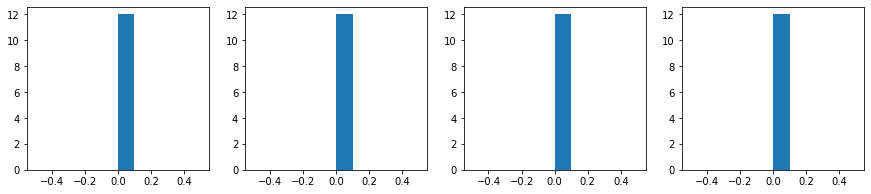

In [199]:
plot_delta_histograms(mod11_mos_arrs, mod12_mos_arrs, mod11_arrs, mod12_arrs)

##### MYD11A2

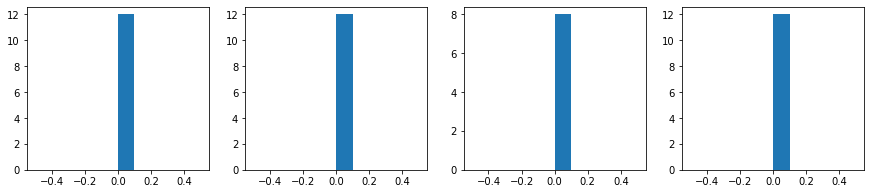

In [200]:
plot_delta_histograms(myd11_mos_arrs, myd12_mos_arrs, myd11_arrs, myd12_arrs)

Mosaicking is valid.

### Read warped MODIS data

In [201]:
# warped MODIS files
mod_warp_dir = os.path.join(scratch_dir, "MODIS", "warped")

mod_warp_fps = sorted(glob.glob(os.path.join(mod_warp_dir, "*MOD11A2*01.tif")))
myd_warp_fps = sorted(glob.glob(os.path.join(mod_warp_dir, "*MYD11A2*01.tif")))

In [202]:
with rio.open(mod_warp_fps[mod_slices[0]][0]) as src:
    tmp_meta = src.meta
    transformer = Transformer.from_crs(4326, src.meta["crs"], always_xy=True)
    mod_warp_coords = [pt for pt in transformer.itransform(test_coords)]
    mod11_warp_id = src.index(*mod_warp_coords[0])
    mod12_warp_id = src.index(*mod_warp_coords[1])
    # read slice
    mod_warp_sl = src.read(1) * 0.02

In [203]:
# extract data
mod11_warp_arrs = extr_arrs(mod_warp_fps, mod_slices, *mod11_warp_id)
mod12_warp_arrs = extr_arrs(mod_warp_fps, mod_slices, *mod12_warp_id)
myd11_warp_arrs = extr_arrs(myd_warp_fps, myd_slices, *mod11_warp_id)
myd12_warp_arrs = extr_arrs(myd_warp_fps, myd_slices, *mod12_warp_id)

### Compare warped data with mosaicked

#### Delta histograms, `warped - mosaicked`

##### MOD11A2

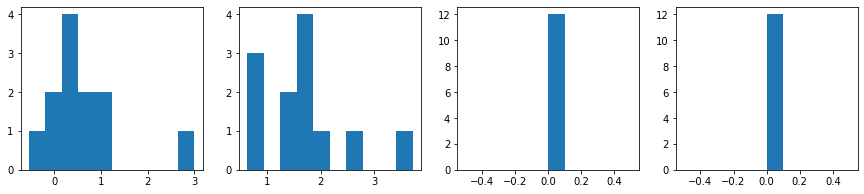

In [204]:
plot_delta_histograms(mod11_warp_arrs, mod12_warp_arrs, mod11_mos_arrs, mod12_mos_arrs)

##### MYD11A2

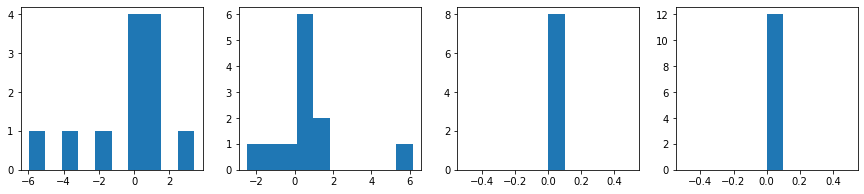

In [205]:
plot_delta_histograms(myd11_warp_arrs, myd12_warp_arrs, myd11_mos_arrs, myd12_mos_arrs)

Slight differences in values from re-projecting is expected. Check for equality at **L2**:

In [206]:
print("L2, P1 elementwise equal:", mod12_warp_arrs[0] == mod12_mos_arrs[0])
print("L2, P2 elementwise equal:", mod12_warp_arrs[1] == mod12_mos_arrs[1])

L2, P1 elementwise equal: [ True  True  True  True  True  True  True  True  True  True  True  True]
L2, P2 elementwise equal: [ True  True  True  True  True  True  True  True  True  True  True  True]


In [207]:
print("", mod11_warp_arrs[0] - mod11_mos_arrs[0])

 [ 0.54  0.22  0.5   0.32  1.14  3.   -0.54 -0.08 -0.04  0.48  0.64  1.12]


Equal values between warp and mosaic for **L2**. Likely just an artifact of increased interpolation from warping at **L1**. Plot first time slice of **P1** for each type to assess warping:

#### Single time slice, 2008-01-01, `mosaicked`, `warped`

##### MOD11A2

In [208]:
mod_mos_sl[mod_mos_sl == 0] = np.nan
mod_warp_sl[mod_warp_sl == 0] = np.nan

In [306]:
# plot both projections with both locations showing
def plot_img_arrs(arr1, arr2, idx1, idx2, adj1=25, adj2=25):
    def set_red(arr, idx, adj):
        for rc in idx:
            arr[rc[0]:rc[0] + adj, rc[1]:rc[1] + adj,:3] = 0.99,0.05,0.75
        return arr

    arrs = [arr1, arr2]
    cmap = plt.cm.viridis
    norms = [plt.Normalize(np.nanmin(arr), np.nanmax(arr)) for arr in arrs]
    rgba = [cmap(norm(arr)) for norm, arr in zip(norms, arrs)]
    rgba[0] = set_red(rgba[0], idx1, adj1)
    rgba[1] = set_red(rgba[1], idx2, adj2)
    fig, ax = plt.subplots(1,2, figsize=(15,20))
    ax[0].imshow(rgba[0], interpolation="none", vmin=220, vmax=295)
    ax[1].imshow(rgba[1], interpolation="none", vmin=220, vmax=295)
    plt.show()

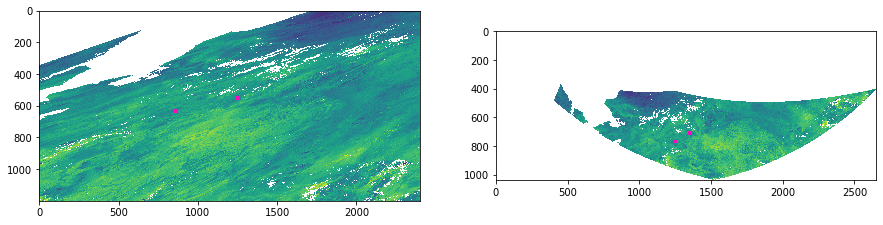

In [210]:
idx1 = [mod11_mos_id, mod12_mos_id]
idx2 = [mod11_warp_id, mod12_warp_id]
plot_img_arrs(mod_mos_sl, mod_warp_sl, idx1, idx2)

Warping is very evident, believe this to be sufficient validation for warped MODIS.

### Read output MODIS data

In [211]:
# prepped MODIS files
out_dir = os.getenv("OUTPUT_DIR")
mod_out_dir = os.path.join(out_dir, "MODIS", "lst_1km_3338_lanczos_multiband")
mod_out_fp = sorted(glob.glob(os.path.join(mod_out_dir, "*.nc")))
myd_out_fp = sorted(glob.glob(os.path.join(mod_out_dir, "*.nc")))

In [212]:
# read and extract final prepped MODIS
def extr_out_arrs(fp, slices, coords):
    ds = xr.open_dataset(fp)
    arr = ds.sel(xc=coords[0], yc=coords[1], method="nearest").lst.values
    out_arr = np.array([arr[slices[0]], arr[slices[1]]])
    out_arr[out_arr == 0] = np.nan
    return out_arr

In [213]:
transformer = Transformer.from_crs(4326, 3338, always_xy=True)
test_coords_3338 = [pt for pt in transformer.itransform(test_coords)]

mod11_out_arrs = extr_out_arrs(mod_out_fp[0], mod_slices, test_coords_3338[0])
mod12_out_arrs = extr_out_arrs(mod_out_fp[0], mod_slices, test_coords_3338[1])
myd11_out_arrs = extr_out_arrs(myd_out_fp[0], mod_slices, test_coords_3338[0])
myd12_out_arrs = extr_out_arrs(myd_out_fp[0], mod_slices, test_coords_3338[1])

### Compare regridded (final) data with warped

#### Delta histograms, `regridded - warped`

##### MOD11A2

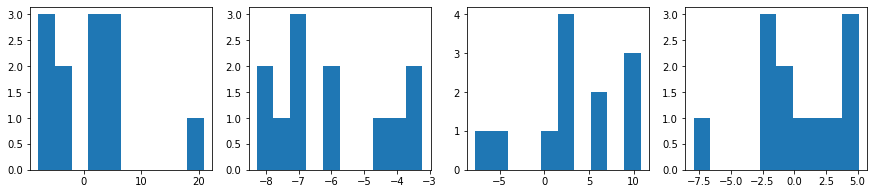

In [214]:
plot_delta_histograms(mod11_out_arrs, mod12_out_arrs, mod11_warp_arrs, mod12_warp_arrs)

##### MYD11A2

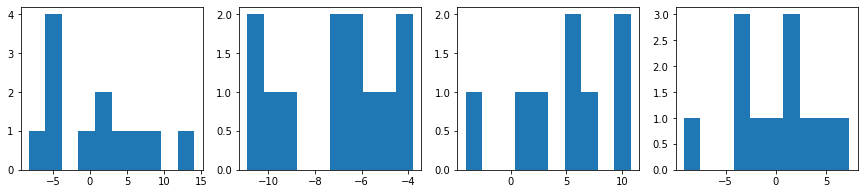

In [215]:
plot_delta_histograms(myd11_out_arrs, myd12_out_arrs, myd11_warp_arrs, myd12_warp_arrs)

Differences are evident, and again, **L1** has larger overall differences. Compare some single time slices to make sure things look similar.

#### Single time slice, 2008-01-01, `warped`, `regridded`

##### MOD11A2

'/home/kmredilla/tech-projects/SERDP-fish-and-fire/project-data/MODIS/lst_1km_3338_lanczos/MOD11A2_A2008001_InteriorAK_006_2015337225218_01.tif'

In [299]:
# read a tif for getting index
mod_tif_out_fps = sorted(glob.glob(os.path.join(mod_out_dir.replace("_multiband", ""), "*.tif")))
mod_tif_out_fp = mod_tif_out_fps[mod_slices[0]][0]
with rio.open(mod_tif_out_fp) as src:
    mod11_out_id = src.index(*test_coords_3338[0])
    mod12_out_id = src.index(*test_coords_3338[1])
    mod_out_sl = src.read(1)
    bounds = src.bounds
mod_out_sl[mod_out_sl <= 1] = np.nan

<ipython-input-299-b36515c7c554>:9: RuntimeWarning: invalid value encountered in less_equal
  mod_out_sl[mod_out_sl <= 1] = np.nan


In [313]:
# get warp tif cropped to output grid
with rio.open(mod_warp_fps[mod_slices[0]][0]) as src:
    ul = src.index(bounds[0], bounds[3])
    br = src.index(bounds[2], bounds[1])
    window = Window.from_slices((ul[0], br[0]), (ul[1], br[1]))
    # read slice
    mod_warp_crop_sl = src.read(1, window=window) * 0.02
#mod_warp_crop_sl[mod_warp_crop_sl == -9999] = np.nan

In [336]:
window = Window.from_slices((676, 832), (1171, 1388))

(676, 1171)

In [337]:
br

(832, 1388)

In [253]:
# get new indices for L1, L2 on cropped warp
mod11_warp_crop_id = (mod11_warp_id[0] - ul[0], mod11_warp_id[1] - ul[1])
mod12_warp_crop_id = (mod12_warp_id[0] - ul[0], mod12_warp_id[1] - ul[1])

In [317]:
np.nanmax(mod_out_sl)

288.76187

In [318]:
#plt.hist(mod_out_sl.flatten())
np.where(mod_out_sl == 288.76187)

(array([213]), array([119]))

In [328]:
mod_out_sl[210:220,115:125]

array([[247.19756, 245.55687, 242.92807, 241.23396, 243.20377, 247.38687,
        249.92206, 249.85109, 248.7112 , 246.36089],
       [246.06284, 244.82172, 242.60965, 237.62357, 240.06822, 248.0503 ,
        247.00829, 243.98875, 243.1228 , 241.62364],
       [245.21872, 244.72287, 245.00255, 248.84673, 248.7572 , 249.47055,
        250.46497, 236.60246, 235.83604, 234.28145],
       [248.33472, 247.62274, 249.03343, 252.4572 , 288.76187, 248.81862,
        250.2581 , 237.60323, 237.505  , 236.7235 ],
       [250.99858, 251.09802, 250.65804, 249.9702 , 250.49289, 248.95895,
        250.53047, 244.91942, 244.9506 , 244.84578],
       [249.61621, 251.37253, 249.92786, 246.3149 , 246.3507 , 251.1891 ,
        252.1248 , 250.47322, 250.32877, 249.28737],
       [247.39963, 249.41359, 248.96031, 245.778  , 247.56084, 252.07588,
        253.70088, 253.30618, 253.71646, 250.3568 ],
       [246.85959, 247.50262, 249.10782, 250.69646, 252.17734, 252.94002,
        253.26889, 249.2951 , 250.260

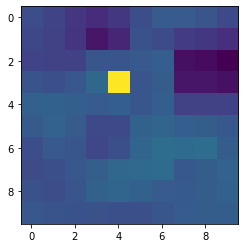

In [327]:
plt.imshow(mod_out_sl[210:220,115:125])

In [322]:
mod_warp_crop_sl.shape

(156, 217)

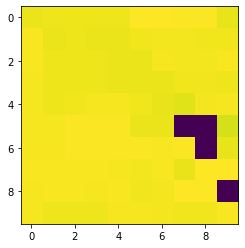

In [325]:
plt.imshow(mod_warp_crop_sl[115:125, 60:70])

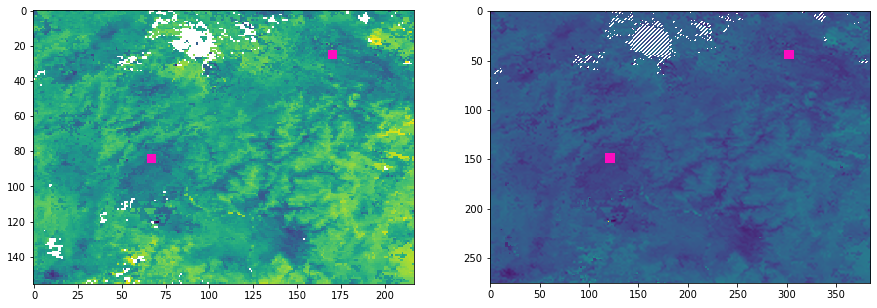

In [307]:
idx1 = [mod11_warp_crop_id, mod12_warp_crop_id]
idx2 = [mod11_out_id, mod12_out_id]
plot_img_arrs(mod_warp_crop_sl, mod_out_sl, idx1, idx2, adj1=5, adj2=10)

## 2. WRF TSK

### Read raw WRF

In [2]:
# setup
wrf_dir = os.getenv("WRF_1KM_DIR")
era_dir = os.path.join(wrf_dir, "era")
# filepaths for each period
wrf_fps = [glob.glob(os.path.join(era_dir, yr, "*.nc")) for yr in ["2008", "2018"]]
wrf_fps = [fp for fp in itertools.chain.from_iterable(wrf_fps)]
# sample filepath
samp_fp = wrf_fps[0]

In [3]:
# get list of variables to drop except time, lat, lon, and tsk
ds = xr.open_dataset(samp_fp)
keep = ["time", "lat", "lon", "TSK"]
drop_vars = [varname for varname in list(ds.variables.keys()) if varname not in keep]
ds.close()

In [4]:
# function to return arr indices of locations
def get_idx(ds,lonlat):
    def dist(arr,lon,lat):
        return math.sqrt((arr[0] - lon)**2 + (arr[1] - lat)**2)
    arr = np.stack((ds.lon.values, ds.lat.values))
    dists = np.apply_along_axis(dist, 0, arr, *lonlat)
    indices = np.where(dists == dists.min())
    return tuple([idx[0] for idx in indices])

In [5]:
# get arr indices of test locations
ds = xr.open_dataset(samp_fp, drop_variables=drop_vars)
L1_idx = get_idx(ds, test_coords[0])
L2_idx = get_idx(ds, test_coords[1])
ds.close()
idxs = [L1_idx, L2_idx]

In [6]:
# get for MODIS 8-day start dates
def get_dates(fp, test_dates):
    fp = mod_dates_fp
    dates = pd.read_csv(fp)
    dates = dates.set_index("time")
    dates = [dates[str(period[0]): str(period[1])].index.values.astype("datetime64") for period in test_dates]
    start = np.array([arr[0:-1] for arr in dates])
    end = np.array([arr[1:] - 1 for arr in dates])
    dates = np.stack([start, end], axis=2)
    return dates

In [7]:
# start dates are equal between MOD and MYD
mod_dates_fp = os.path.join(scratch_dir, "WRF", "WRF_day_hours", "tsk", "tsk_8Day_daytime_wrf_era_mean_MOD11A2_times.csv")
# myd_dates_fp = os.path.join(scratch_dir, "WRF", "WRF_day_hours", "tsk", "tsk_8Day_daytime_wrf_era_mean_MYD11A2_times.csv")
dates = get_dates(mod_dates_fp, test_dates)
# myd_dates = get_dates(myd_dates_fp, test_dates)

In [18]:
# subset filepaths by dates for efficiency
fp_dates = [pd.date_range(dates[0], dates[1]).date.tolist() for dates in test_dates]
fp_dates = [str(date) for date in itertools.chain.from_iterable(fp_dates)]
wrf_fps = [fp for fp in wrf_fps if fp.split("_")[-2] in fp_dates]

In [144]:
def get_day_hours(hr):
    return (hr >= 9) & (hr <= 17)

def get_day_hours_ds(ds):
    ds_sel = ds.sel(Time=get_day_hours(ds["time.hour"]))
    return ds_sel

def extr_arrs(ds, dates, idxs):
    arr = ds.TSK.values
    times = pd.to_datetime(ds.time.values)
    # extract from array based on indicies of time array using index slicer
    L1,L2 = [],[]
    out_sl = []
    for period in dates:
        slices = [times.slice_indexer(*daterange) for daterange in period]
        out_sl.append(slices)
        L1.append([np.mean(arr[sl, idxs[0][0], idxs[0][1]]) for sl in slices])
        L2.append([np.mean(arr[sl, idxs[1][0], idxs[1][1]]) for sl in slices])
    # return slices used for WRF as well
    return(np.array([np.array(L1), np.array(L2)]))

In [146]:
tic = time.perf_counter()

# read in raw WRF, takes a couple minutes
ds = xr.open_mfdataset(
    wrf_fps,
    drop_variables=drop_vars + ["lat", "lon"],
    concat_dim="Time",
    combine="nested",
    preprocess=get_day_hours_ds,
).load()

print(round(time.perf_counter() - tic, 1), "s")

195.8 s


In [147]:
ds.close()

In [148]:
wrf_arrs = extr_arrs(ds, dates, idxs)

### Read output WRF

In [166]:
wrf_out_dir = os.path.join(out_dir, "WRF", "tsk_1km_3338_multiband")
wrf_out_fp = glob.glob(os.path.join(wrf_out_dir, "*era_mean_MOD*.nc"))[0]
wrf_out_ds = xr.open_dataset(wrf_out_fp)
wrf_out_ds.close()

In [186]:
def extr_wrf_out_arrs(ds, coords, dates):
    out_arrs = []
    for coords, pdates in itertools.product(test_coords_3338, dates):
        sds = ds.sel(xc=coords[0], yc=coords[1], method="nearest")
        out_arrs.append(np.array([sds.sel(date=slice(*daterange)).tsk.values[0] for daterange in pdates]))
    out_arrs = np.array([out_arrs[:2], out_arrs[2:]])
    return out_arrs

In [187]:
wrf_out_arrs = extr_wrf_out_arrs(wrf_out_ds, test_coords_3338, dates)

### Compare raw data with output (final)

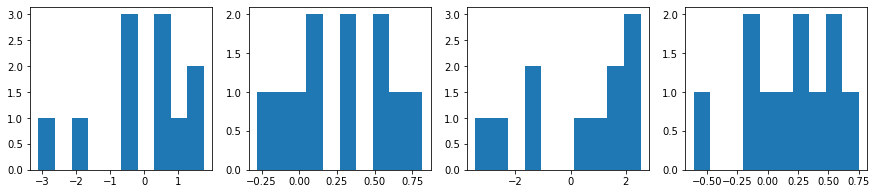

In [188]:
plot_delta_histograms(wrf_out_arrs[0], wrf_out_arrs[1], wrf_arrs[0], wrf_arrs[1])

These are the types of subtle differences I would expect from warping 4326 to 3338. 